In [1]:
import sys
sys.path.append('../')

In [22]:
import numpy as np
from numpy.linalg import norm
import pandas as pd
import os

import matplotlib.pyplot as plt

In [3]:
plt.style.use('seaborn-v0_8-colorblind')
plt.style.use({'axes.grid': True,
               'font.family': 'Times New Roman',
               'font.sans-serif': ['Bitstream Vera Sans'],
               'text.usetex': True,
               'mathtext.fontset': 'stixsans',
               'xtick.direction': 'out',
               'ytick.direction': 'out',
               'savefig.dpi': 100})

In [5]:
datapath = '/home/tnguser/frb_project/data/test_flat_res001.hdf5'

In [6]:
df = pd.read_hdf(datapath)

(0.0, 133095.2)

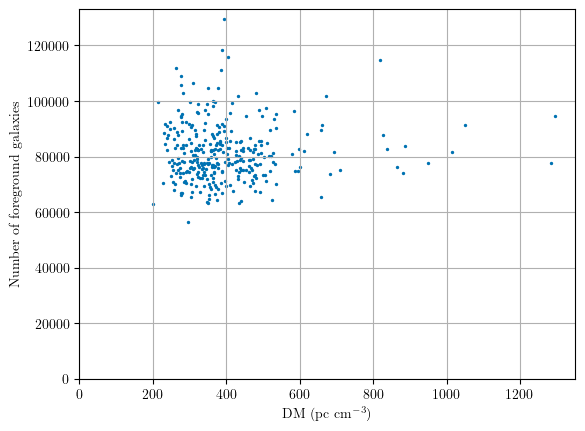

In [8]:
plt.scatter(df['DM'], df['N_g'], s=2)
plt.xlabel(r'DM (pc cm$^{-3}$)')
plt.ylabel('Number of foreground galaxies')
plt.xlim(left=0)
plt.ylim(bottom=0)

See https://numpy.org/doc/stable/reference/routines.fft.html#module-numpy.fft for how the 2D FFT is done

In [78]:
def cross_power_estimator(arr_a, arr_b, s):
    # s: pixel size

    N_0, N_1 = arr_a.shape
    
    f_a = np.fft.fft2(arr_a/np.sum(arr_a))
    f_b = np.fft.fft2(arr_b/np.sum(arr_b)) #normalize
    
    # scale
    vec_ells = (2*np.pi/s)*np.indices((N_0, N_1))
    vec_ells[0] = vec_ells[0]/N_0
    vec_ells[1] = vec_ells[1]/N_1
    ells = norm(vec_ells, axis=0)
    
    unique_ells = np.unique(ells)
    Clabs = []
    for ell in unique_ells:
        mask = np.isclose(ells, ell)
        Clabs.append(np.average(np.conjugate(f_a[mask])*f_b[mask]))
    
    return unique_ells[1:], np.array(Clabs)[1:] #discard ell that corresponds to size of box

In [73]:
DMs = np.array(df['DM']).reshape((18,18))
N_gs = np.array(df['N_g']).reshape((18,18))
ells, C_ls = cross_power_estimator(DMs, N_gs, 0.01)

Text(0.5, 0, '$\\ell$')

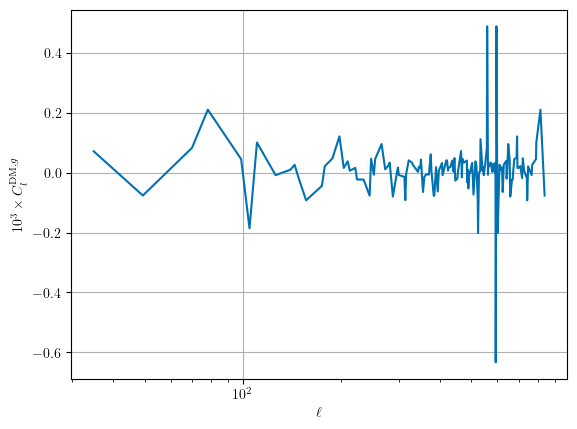

In [77]:
plt.plot(ells, np.real(C_ls)*1000)
plt.xscale('log')
plt.ylabel(r'$10^3 \times C_l^{\mathrm{DM}, g}$')
plt.xlabel(r'$\ell$')

In [80]:
from illustris_frb import frb_simulation
import healpy as hp

gcat_path = '/home/tnguser/frb_project/data/g_cats/test_flat' #where
outpath = '/home/tnguser/frb_project/data/test_flat_res001.hdf5'

binsize = 500
origin = binsize * np.array([50, 70, 23]) # same origin as in DM_redshift.ipynb
z = 0.4 # place galaxies at z=0.4

theta_min = np.pi/2 - 0.09
theta_max = np.pi/2 + 0.09
phi_min = 0.01
phi_max = 0.19 #see get_good_pixels.ipynb
#.18 x .18 rad region

res = 0.01 #324 FRBs

## --- END OF INPUTS ---

sim = frb_simulation('L205n2500TNG', origin=origin, max_z=z)
x = sim.comoving_distance(z)

theta_grid = np.arange(theta_min, theta_max+res/2, res)
phi_grid = np.arange(phi_min, phi_max+res/2, res) #bin edges
n_x = len(theta_grid)-1
n_y = len(phi_grid)-1
N = n_x * n_y

pix_angs = np.array(np.meshgrid(theta_grid[:-1]+res/2, 
                                phi_grid[:-1]+res/2)).T.reshape(N,2)
pix_vecs = x * hp.ang2vec(pix_angs[:,0], pix_angs[:,1])